In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torchvision.datasets as dset

In [4]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:1" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:1
Device count: 2
Device name: NVIDIA GeForce RTX 3060 Ti


In [5]:
#Lambda function to scale -1,1 interval the mnist 255 pixel image
transform_scale_pixel = lambda pixel: (pixel-127.5)/127.5
image_size = 16
dataroot = "C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/"
transform_flatten = lambda pixel: torch.flatten(pixel)
transform_minusone_plusone = tt.Compose([
                                     tt.PILToTensor(),
                                     tt.Lambda(transform_scale_pixel),
                                     tt.Lambda(transform_flatten)
                                           ])
transform_zero_plusone=tt.Compose([
                                    tt.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))
                                  ])
transform_downscale_to_imagesize=tt.Compose([
                               tt.Resize(image_size),
                               tt.CenterCrop(image_size),
                                tt.PILToTensor(),
                                tt.Lambda(transform_scale_pixel),
                                tt.Lambda(transform_flatten)
                           ])

In [6]:
#torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
training_data = dset.MNIST(root=dataroot,
                     train=True,
                     transform=transform_minusone_plusone
                           )

In [4]:
#torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
training_data_downscaled = dset.MNIST(root=dataroot,
                     train=True,
                     transform=transform_downscale_to_imagesize
                           )

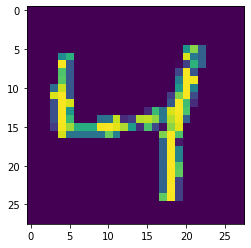

In [7]:
test=tt.functional.to_pil_image(training_data[2][0].reshape(28,28))
plt.imshow(test)

In [5]:
test=tt.functional.to_pil_image(training_data_downscaled[130][0].reshape(16,16))
plt.imshow(test)

NameError: name 'training_data_downscaled' is not defined

In [7]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlowMNISTReduced(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlowMNISTReduced, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(128, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(128, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :128], x[:, 128:]
            #print(x.shape)
            #print(y1.shape)
            #print(y2.shape)
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    #print(x1.shape)
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :128], x[:, 128:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [8]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module
        self.training = True

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlowMNIST(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlowMNIST, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(392, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(392, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if self.training:
            s_vals = []
            y1, y2 = x[:, :392], x[:, 392:]
            #print(x.shape)
            #print(y1.shape)
            #print(y2.shape)
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    #print(x1.shape)
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :392], x[:, 392:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10):
    size = len(dataloader)
    for batch, X in enumerate(dataloader):
        # Transfer to GPU
        #print(X.shape)
        #print("Train loop")
        train_samples = X[0]
        batch_classes = X[1]
        train_samples = train_samples.float().to(device)
        
        # Compute prediction and loss
        y, s = model(train_samples)
        loss = loss_fn(y, s, batch_size)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            y, s = model(X)
            test_loss += loss_fn(y, s, batch_size)

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [10]:
def loss_fn(y, s, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2
    logpx = -torch.sum(0.5 * y**2)
    det = torch.sum(s)
    
    ret = -(logpx + det)
    return torch.div(ret, batch_size)

In [13]:
learning_rate = 1e-3
batch_size = 5000
epochs = 5000
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_low_variance_test.pt"]
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture.pt"]
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_sqrt_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_sqrt_matrix_project_to_4d_plane.pt"]
#datasets = ["C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_low_variance_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_gmm_varied_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/blobs_high_std_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/no_structure_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_circles_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/noisy_moons_high_noise_quadratic_matrix_project_to_4d_plane.pt","C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/data/2D/2d_t_mixture_quadratic_matrix_project_to_4d_plane.pt"]
models = []
orig_data = []
num_coupling_array=[4,8,16,32,64,80,96,102]
width_array=[2,5,10,20,40,50,60,70]
result_dir='C:/Users/aligursu/Desktop/Dersler/Tez_kodlar/trained_models/'

In [14]:
num_coupling_array=[80,96,102]
width_array=[50,60,70]

In [10]:
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):
    model = NormalizingFlowMNISTReduced(num_coupling=num_coupling, width=width).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_dataloader = DataLoader(training_data_downscaled, batch_size=batch_size, shuffle=True)
    print(f"\n======================================\MNIST16x16\n======================================")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, report_iters=1)
    torch.save(model.state_dict(),result_dir+ 'MNIST16x16' +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model')

NameError: name 'NormalizingFlowMNISTReduced' is not defined

In [16]:
for i,(num_coupling,width) in enumerate(zip(num_coupling_array, width_array)):
    model = NormalizingFlowMNIST(num_coupling=num_coupling, width=width).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    print(f"\n======================================\MNIST28x28\n======================================")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, report_iters=12)
    torch.save(model.state_dict(),result_dir+ 'MNIST28' +'_complexity_' +'num_coupling_' +str(num_coupling) +'_width_'+ str(width) + '.model')


======================================\MNIST28x28
Epoch 1
-------------------------------
loss: 879.044495  [    0/   12]
Epoch 2
-------------------------------
loss: -4.865200  [    0/   12]
Epoch 3
-------------------------------
loss: -578.406067  [    0/   12]
Epoch 4
-------------------------------
loss: -481.844940  [    0/   12]
Epoch 5
-------------------------------
loss: -827.901306  [    0/   12]
Epoch 6
-------------------------------
loss: -875.981873  [    0/   12]
Epoch 7
-------------------------------
loss: -1073.048584  [    0/   12]
Epoch 8
-------------------------------
loss: -1037.292236  [    0/   12]
Epoch 9
-------------------------------
loss: -1077.587158  [    0/   12]
Epoch 10
-------------------------------
loss: -1099.215332  [    0/   12]
Epoch 11
-------------------------------
loss: -264.589996  [    0/   12]
Epoch 12
-------------------------------
loss: -806.353760  [    0/   12]
Epoch 13
-------------------------------
loss: -1056.710938  [    0/ 

loss: -2462.773193  [    0/   12]
Epoch 110
-------------------------------
loss: -2383.865234  [    0/   12]
Epoch 111
-------------------------------
loss: -2360.144775  [    0/   12]
Epoch 112
-------------------------------
loss: -2508.104248  [    0/   12]
Epoch 113
-------------------------------
loss: -2447.837402  [    0/   12]
Epoch 114
-------------------------------
loss: -2214.654541  [    0/   12]
Epoch 115
-------------------------------
loss: -2539.291992  [    0/   12]
Epoch 116
-------------------------------
loss: -2429.463623  [    0/   12]
Epoch 117
-------------------------------
loss: -2514.624268  [    0/   12]
Epoch 118
-------------------------------
loss: -2622.669922  [    0/   12]
Epoch 119
-------------------------------
loss: -2604.834717  [    0/   12]
Epoch 120
-------------------------------
loss: -2496.687500  [    0/   12]
Epoch 121
-------------------------------
loss: -2617.114014  [    0/   12]
Epoch 122
-------------------------------
loss: -2581.

loss: -2649.858154  [    0/   12]
Epoch 218
-------------------------------
loss: -2656.344482  [    0/   12]
Epoch 219
-------------------------------
loss: -2601.477051  [    0/   12]
Epoch 220
-------------------------------
loss: -2541.601562  [    0/   12]
Epoch 221
-------------------------------
loss: -2690.460938  [    0/   12]
Epoch 222
-------------------------------
loss: -2632.043213  [    0/   12]
Epoch 223
-------------------------------
loss: -2619.825928  [    0/   12]
Epoch 224
-------------------------------
loss: -2710.497070  [    0/   12]
Epoch 225
-------------------------------
loss: -2796.470947  [    0/   12]
Epoch 226
-------------------------------
loss: -2614.969238  [    0/   12]
Epoch 227
-------------------------------
loss: -2758.431152  [    0/   12]
Epoch 228
-------------------------------
loss: -2738.620605  [    0/   12]
Epoch 229
-------------------------------
loss: -2773.934326  [    0/   12]
Epoch 230
-------------------------------
loss: -2667.

loss: -3201.952637  [    0/   12]
Epoch 326
-------------------------------
loss: -3300.351562  [    0/   12]
Epoch 327
-------------------------------
loss: -3294.043945  [    0/   12]
Epoch 328
-------------------------------
loss: -3168.896240  [    0/   12]
Epoch 329
-------------------------------
loss: -3162.834961  [    0/   12]
Epoch 330
-------------------------------
loss: -3190.665527  [    0/   12]
Epoch 331
-------------------------------
loss: -3294.377441  [    0/   12]
Epoch 332
-------------------------------
loss: -3225.526367  [    0/   12]
Epoch 333
-------------------------------
loss: -3052.588623  [    0/   12]
Epoch 334
-------------------------------
loss: -3311.005127  [    0/   12]
Epoch 335
-------------------------------
loss: -3311.407227  [    0/   12]
Epoch 336
-------------------------------
loss: -3235.044189  [    0/   12]
Epoch 337
-------------------------------
loss: -3300.055420  [    0/   12]
Epoch 338
-------------------------------
loss: -3200.

Epoch 33
-------------------------------
loss: -1609.084595  [    0/   12]
Epoch 34
-------------------------------
loss: -1817.908813  [    0/   12]
Epoch 35
-------------------------------
loss: -1702.678711  [    0/   12]
Epoch 36
-------------------------------
loss: -1750.419800  [    0/   12]
Epoch 37
-------------------------------
loss: -1895.071533  [    0/   12]
Epoch 38
-------------------------------
loss: -1752.824341  [    0/   12]
Epoch 39
-------------------------------
loss: -1715.987549  [    0/   12]
Epoch 40
-------------------------------
loss: -1762.188721  [    0/   12]
Epoch 41
-------------------------------
loss: -1756.438721  [    0/   12]
Epoch 42
-------------------------------
loss: -1938.862793  [    0/   12]
Epoch 43
-------------------------------
loss: -1915.407593  [    0/   12]
Epoch 44
-------------------------------
loss: -1796.447388  [    0/   12]
Epoch 45
-------------------------------
loss: -1834.685547  [    0/   12]
Epoch 46
----------------

Epoch 142
-------------------------------
loss: -2483.467529  [    0/   12]
Epoch 143
-------------------------------
loss: -2664.899414  [    0/   12]
Epoch 144
-------------------------------
loss: -2644.321289  [    0/   12]
Epoch 145
-------------------------------
loss: -2679.322021  [    0/   12]
Epoch 146
-------------------------------
loss: -2664.415039  [    0/   12]
Epoch 147
-------------------------------
loss: -2548.591797  [    0/   12]
Epoch 148
-------------------------------
loss: -2474.734619  [    0/   12]
Epoch 149
-------------------------------
loss: -2204.921631  [    0/   12]
Epoch 150
-------------------------------
loss: -2495.153809  [    0/   12]
Epoch 151
-------------------------------
loss: -2169.826660  [    0/   12]
Epoch 152
-------------------------------
loss: -2574.489990  [    0/   12]
Epoch 153
-------------------------------
loss: -2543.395020  [    0/   12]
Epoch 154
-------------------------------
loss: -2657.686035  [    0/   12]
Epoch 155
--

Epoch 250
-------------------------------
loss: -2877.526123  [    0/   12]
Epoch 251
-------------------------------
loss: -2827.831055  [    0/   12]
Epoch 252
-------------------------------
loss: -2818.337891  [    0/   12]
Epoch 253
-------------------------------
loss: -2871.084229  [    0/   12]
Epoch 254
-------------------------------
loss: -2854.544922  [    0/   12]
Epoch 255
-------------------------------
loss: -2877.643799  [    0/   12]
Epoch 256
-------------------------------
loss: -2869.876221  [    0/   12]
Epoch 257
-------------------------------
loss: -2832.308105  [    0/   12]
Epoch 258
-------------------------------
loss: -2694.381592  [    0/   12]
Epoch 259
-------------------------------
loss: -2777.107178  [    0/   12]
Epoch 260
-------------------------------
loss: -2857.934814  [    0/   12]
Epoch 261
-------------------------------
loss: -2813.174316  [    0/   12]
Epoch 262
-------------------------------
loss: -2939.610107  [    0/   12]
Epoch 263
--

Epoch 358
-------------------------------
loss: -3097.001709  [    0/   12]
Epoch 359
-------------------------------
loss: -3135.534424  [    0/   12]
Epoch 360
-------------------------------
loss: -3126.602295  [    0/   12]
Epoch 361
-------------------------------
loss: -3159.935547  [    0/   12]
Epoch 362
-------------------------------
loss: -3134.767822  [    0/   12]
Epoch 363
-------------------------------
loss: -3144.550781  [    0/   12]
Epoch 364
-------------------------------
loss: -2729.584961  [    0/   12]
Epoch 365
-------------------------------
loss: -3129.088379  [    0/   12]
Epoch 366
-------------------------------
loss: -3083.839111  [    0/   12]
Epoch 367
-------------------------------
loss: -3015.279053  [    0/   12]
Epoch 368
-------------------------------
loss: -3073.332275  [    0/   12]
Epoch 369
-------------------------------
loss: -3130.465820  [    0/   12]
Epoch 370
-------------------------------
loss: -3118.522461  [    0/   12]
Epoch 371
--

RuntimeError: CUDA out of memory. Tried to allocate 764.00 MiB (GPU 1; 8.00 GiB total capacity; 5.51 GiB already allocated; 23.75 MiB free; 6.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF